In [1]:
import numpy as np
import pandas as pd
import imageio
import os
from sklearn.metrics import matthews_corrcoef, accuracy_score, f1_score
# import higra as hg

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import cv2
import sys
sys.path.append('../../resuneta/src')

from bound_dist import get_boundary

# Test set metrics

In [3]:
# shared function(s)
def get_mask(extent, boundary_kernel_size=(2,2)):
    boundary = get_boundary(extent, kernel_size=boundary_kernel_size)
    mask = np.array((extent + boundary) >= 1, dtype=np.uint8)
    return mask

## Airbus

In [4]:
def get_test_set_mcc(image_ids, pred_folder_name, 
                     label_folder_name='planet/india/GeneralBlockchain/extent_labels_',
                     fold='test', threshold=0.5):
    labels = []
    predictions = []
#     image_mccs = []

    for image_id in image_ids:
        if os.path.exists(os.path.join(label_folder_name, 'airbus_geowiki_C{}.png'.format(image_id))):
            extent = imageio.imread(os.path.join(label_folder_name, 'airbus_geowiki_C{}.png'.format(image_id)))
            pred = imageio.imread( # np.load
                os.path.join('../results/india/GeneralBlockchain/',
                             pred_folder_name,
                             'extent_full', # extent_predictions
                             'airbus_geowiki_C{}.png'.format(image_id))) # 'airbus_geowiki_C{}.npy'.format(image_id)))

            mask = get_mask(extent)
            mask_flat = mask.flatten()

            indices = np.where(mask_flat == 1)[0]
            extent_flat = extent.flatten()
            field_and_border = extent_flat[indices]

            pred_flat = pred.flatten() / 255.
            prediction = pred_flat[indices]
            prediction = np.array(prediction > threshold, dtype=np.uint8)

    #         mcc = matthews_corrcoef(field_and_border, prediction)
    #         image_mccs.append(mcc)

            labels = labels + list(field_and_border)
            predictions = predictions + list(prediction)
        
    return matthews_corrcoef(labels, predictions)

In [5]:
def get_test_set_metrics(image_ids, pred_folder_name, 
                     label_folder_name='planet/india/GeneralBlockchain/extent_labels_',
                     fold='test', threshold=0.5):
    labels = []
    predictions = []
#     image_mccs = []

    for image_id in image_ids:
        if os.path.exists(os.path.join(label_folder_name, 'airbus_geowiki_C{}.png'.format(image_id))):
            extent = imageio.imread(os.path.join(label_folder_name, 'airbus_geowiki_C{}.png'.format(image_id)))
            pred = imageio.imread( # np.load
                os.path.join('../results/india/GeneralBlockchain/',
                             pred_folder_name,
                             'extent_full', # extent_predictions
                             'airbus_geowiki_C{}.png'.format(image_id))) # 'airbus_geowiki_C{}.npy'.format(image_id)))

            mask = get_mask(extent)
            mask_flat = mask.flatten()

            indices = np.where(mask_flat == 1)[0]
            extent_flat = extent.flatten()
            field_and_border = extent_flat[indices]

            pred_flat = pred.flatten() / 255.
            prediction = pred_flat[indices]
            prediction = np.array(prediction > threshold, dtype=np.uint8)

    #         mcc = matthews_corrcoef(field_and_border, prediction)
    #         image_mccs.append(mcc)

            labels = labels + list(field_and_border)
            predictions = predictions + list(prediction)
        
    return matthews_corrcoef(labels, predictions), accuracy_score(labels, predictions), f1_score(labels, predictions)

In [6]:
def get_individual_test_set_metrics(image_ids, pred_folder_name, 
                     label_folder_name='planet/india/GeneralBlockchain/extent_labels_',
                     fold='test', threshold=0.5):
    
    new_ids = []
    image_mccs = []
    image_accs = []
    image_f1s = []

    for image_id in image_ids:
        if os.path.exists(os.path.join(label_folder_name, 'airbus_geowiki_C{}.png'.format(image_id))):
            extent = imageio.imread(os.path.join(label_folder_name, 'airbus_geowiki_C{}.png'.format(image_id)))
            pred = imageio.imread( # np.load
                os.path.join('../results/india/GeneralBlockchain/',
                             pred_folder_name,
                             'extent_full', # extent_predictions
                             'airbus_geowiki_C{}.png'.format(image_id))) # 'airbus_geowiki_C{}.npy'.format(image_id)))

            mask = get_mask(extent)
            mask_flat = mask.flatten()

            indices = np.where(mask_flat == 1)[0]
            extent_flat = extent.flatten()
            field_and_border = extent_flat[indices]

            pred_flat = pred.flatten() / 255.
            prediction = pred_flat[indices]
            prediction = np.array(prediction > threshold, dtype=np.uint8)

            mcc = matthews_corrcoef(field_and_border, prediction)
            acc = accuracy_score(field_and_border, prediction)
            f1 = f1_score(field_and_border, prediction)
            
            new_ids.append(image_id)
            image_mccs.append(mcc)
            image_accs.append(acc)
            image_f1s.append(f1)
    
    return new_ids, image_mccs, image_accs, image_f1s

In [8]:
splits_df = pd.read_csv('../data/splits/india_planetImagery_splits_20x20_v2.csv')
splits_df['image_id'] = splits_df['image_id'].astype(str).str.zfill(4)
# image_ids = splits_df[splits_df['fold'] == 'test']['image_id'].values
image_ids = splits_df[splits_df['fold'] == 'val']['image_id'].values
splits_df.head()

,image_id,lat,lon,fold
0,0000,26.291410,73.095543,test
1,0115,26.008257,72.935907,test
2,0501,22.716429,82.110905,train
3,0781,22.557453,85.232995,test
4,0794,25.755859,82.609664,train


### Labels created via 2px erosion

#### Original France resolution

##### Trained on full labels, applied to Airbus original

In [13]:
# trained on FULL LABELS France original resolution
fold = 'val'
image_ids = splits_df[splits_df['fold'] == fold]['image_id'].values
mccs = []
threshs = np.linspace(0.3, 0.5, 21)
for thresh in threshs:
    print(thresh)
    mcc = get_test_set_mcc(
        image_ids,
        'full-france_fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2/Airbus_original',
        label_folder_name='../data/general_blockchain/airbus_labels/large/original/',
        fold=fold,
        threshold=thresh
    )
    mccs.append(mcc)

0.3
0.31
0.32
0.32999999999999996
0.33999999999999997
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.44999999999999996
0.45999999999999996
0.47
0.48
0.49
0.5


In [14]:
print("Best MCC thresh:", threshs[np.argmax(mccs)])
print("Best val MCC:", np.max(mccs))

Best MCC thresh: 0.32
Best val MCC: 0.16831523394576853


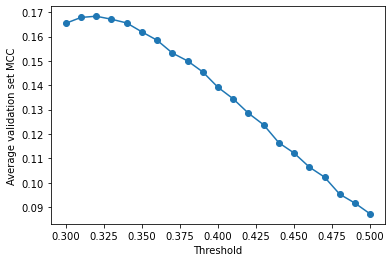

In [15]:
plt.plot(threshs, mccs, 'o-')
plt.xlabel('Threshold')
plt.ylabel('Average validation set MCC')
plt.show()

In [16]:
# test set: ALL METRICS
fold = 'test'
image_ids = splits_df[splits_df['fold'] == fold]['image_id'].values
mcc, acc, f1 = get_test_set_metrics(
    image_ids,
    'full-france_fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2/Airbus_original',
    label_folder_name='../data/general_blockchain/airbus_labels/large/original/',
    fold=fold,
    threshold=0.32
)
print("Test set MCC: {:.3f}, accuracy: {:.3f}, f1-score: {:.3f}".format(mcc, acc, f1))

Test set MCC: 0.169, accuracy: 0.835, f1-score: 0.907


##### Applied to Airbus original

In [23]:
# trained on France original resolution separately, run #2
fold = 'val'
image_ids = splits_df[splits_df['fold'] == fold]['image_id'].values
mccs = []
threshs = np.linspace(0.5, 0.7, 21)
for thresh in threshs:
    print(thresh)
    mcc = get_test_set_mcc(
        image_ids,
        'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2/Airbus_original',
        label_folder_name='../data/general_blockchain/airbus_labels/large/original/',
        fold=fold,
        threshold=thresh
    )
    mccs.append(mcc)

0.5
0.51
0.52
0.53
0.54
0.55
0.5599999999999999
0.57
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.6499999999999999
0.6599999999999999
0.6699999999999999
0.6799999999999999
0.69
0.7


In [25]:
print("Best MCC thresh:", threshs[np.argmax(mccs)])
print("Best val MCC:", np.max(mccs))

Best MCC thresh: 0.6699999999999999
Best val MCC: 0.3740031062673119


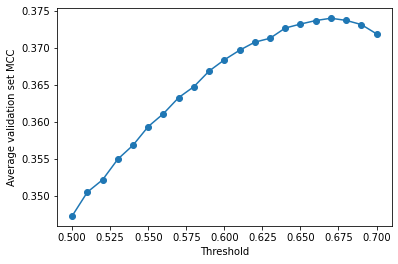

In [26]:
plt.plot(threshs, mccs, 'o-')
plt.xlabel('Threshold')
plt.ylabel('Average validation set MCC')
plt.show()

In [29]:
# test set
fold = 'test'
image_ids = splits_df[splits_df['fold'] == fold]['image_id'].values
mcc = get_test_set_mcc(
    image_ids,
    'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2/Airbus_original',
    label_folder_name='../data/general_blockchain/airbus_labels/large/original/',
    fold=fold,
    threshold=threshs[np.argmax(mccs)] # 0.67
)
print("Test set MCC:", mcc)

Test set MCC: 0.3748021141628282


In [10]:
# test set: ALL METRICS
fold = 'test'
image_ids = splits_df[splits_df['fold'] == fold]['image_id'].values
mcc, acc, f1 = get_test_set_metrics(
    image_ids,
    'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-7_lr-0.001_1x-downsampled_allfields_n6759_1250px_thickness2/Airbus_original',
    label_folder_name='../data/general_blockchain/airbus_labels/large/original/',
    fold=fold,
    threshold=0.67
)
print("Test set MCC: {:.3f}, accuracy: {:.3f}, f1-score: {:.3f}".format(mcc, acc, f1))

Test set MCC: 0.375, accuracy: 0.866, f1-score: 0.924


In [8]:
# trained on France original resolution separately
fold = 'val'
image_ids = splits_df[splits_df['fold'] == fold]['image_id'].values
mccs = []
threshs = np.linspace(0.4, 0.8, 31)
for thresh in threshs:
    print(thresh)
    mcc = get_test_set_mcc(
        image_ids,
        'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_1x-downsampled_allfields_n6759/Airbus_original',
        label_folder_name='general_blockchain/airbus_labels/large/original_',
        fold=fold,
        threshold=thresh
    )
    mccs.append(mcc)

0.4
0.41333333333333333
0.4266666666666667
0.44
0.45333333333333337
0.4666666666666667
0.48000000000000004
0.49333333333333335
0.5066666666666667
0.52
0.5333333333333333
0.5466666666666666
0.56
0.5733333333333334
0.5866666666666667
0.6000000000000001
0.6133333333333334
0.6266666666666667
0.64
0.6533333333333333
0.6666666666666667
0.68
0.6933333333333334
0.7066666666666668
0.72
0.7333333333333334
0.7466666666666667
0.76
0.7733333333333334
0.7866666666666667
0.8


In [10]:
np.max(mccs)

0.3228052425442077

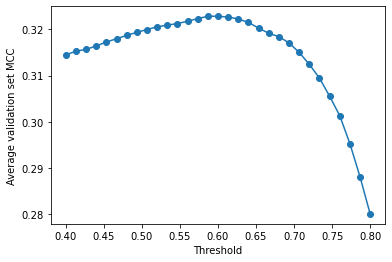

In [9]:
plt.plot(threshs, mccs, 'o-')
plt.xlabel('Threshold')
plt.ylabel('Average validation set MCC')
plt.show()

##### Applied to Airbus 3x downsampled

In [12]:
# trained on France original resolution separately
fold = 'val'
image_ids = splits_df[splits_df['fold'] == fold]['image_id'].values
mccs = []
threshs = np.linspace(0.4, 0.8, 31)
for thresh in threshs:
    mcc = get_test_set_mcc(
        image_ids,
        'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_1x-downsampled_allfields_n6759/Airbus_3x_downsampled',
        label_folder_name='general_blockchain/airbus_labels/large/3x_downsample_erosion1px_',
        fold=fold,
        threshold=thresh
    )
    mccs.append(mcc)

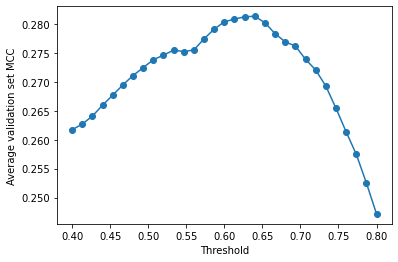

In [13]:
plt.plot(threshs, mccs, 'o-')
plt.xlabel('Threshold')
plt.ylabel('Average validation set MCC')
plt.show()

In [17]:
# trained on France original resolution separately
image_ids = splits_df[splits_df['fold'] == 'test']['image_id'].values
get_test_set_mcc(image_ids,
                 'fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_1x-downsampled_allfields_n6759/Airbus_3x_downsampled',
                 label_folder_name='general_blockchain/airbus_labels/large/3x_downsample_erosion1px_', fold='test', threshold=0.64)

0.26152623997612157

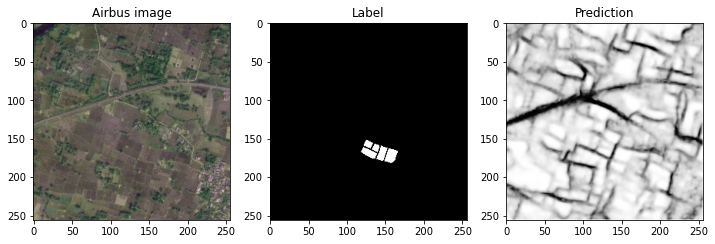

In [18]:
img = imageio.imread('../data/general_blockchain/airbus_false_color/large/3x_downsample_test/airbus_geowiki_C0006.png')
extent = imageio.imread('../data/general_blockchain/airbus_labels/large/3x_downsample_erosion1px_test/airbus_geowiki_C0006.png')
pred = np.load('../results/india/GeneralBlockchain/fractal-resunet_3month-separate_nfilter-32_depth-6_bs-8_lr-0.001_1x-downsampled_allfields_n6759/Airbus_3x_downsampled/extent_predictions/airbus_geowiki_C0006.npy')

fig, ax = plt.subplots(1, 3, figsize=(12,4))
ax[0].imshow(img)
ax[1].imshow(extent, cmap='Greys_r', vmin=0, vmax=1)
ax[2].imshow(pred, cmap='Greys_r', vmin=0, vmax=1)
ax[0].set_title('Airbus image')
ax[1].set_title('Label')
ax[2].set_title('Prediction')
plt.show()

#### Trained on 1x France Planet, fine-tuned on 1x India Airbus

In [37]:
# fine tuned in India
fold = 'val'
image_ids = splits_df[splits_df['fold'] == fold]['image_id'].values
# mccs = []
threshs = np.linspace(0.6, 0.7, 11)
for thresh in threshs:
    print(thresh)
    mcc = get_test_set_mcc(
        image_ids,
        'fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.0001_original_finetuned2-continued/Airbus_original',
        label_folder_name='../data/general_blockchain/airbus_labels/large/original/',
        fold=fold,
        threshold=thresh
    )
    mccs.append(mcc)

0.6
0.61
0.62
0.63
0.64
0.6499999999999999
0.6599999999999999
0.6699999999999999
0.6799999999999999
0.69
0.7


In [42]:
print("Best MCC thresh:", threshs[np.argmax(mccs[-11:])])
print("Best val MCC:", np.max(mccs[-11:]))

Best MCC thresh: 0.6599999999999999
Best val MCC: 0.49093216558042096


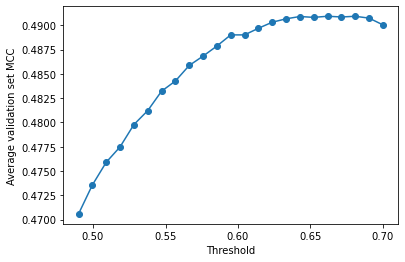

In [38]:
# plt.plot(threshs, mccs, 'o-')
plt.plot(np.linspace(0.49, 0.7, 23), mccs, 'o-')
plt.xlabel('Threshold')
plt.ylabel('Average validation set MCC')
plt.show()

In [52]:
# test set
fold = 'test'
image_ids = splits_df[splits_df['fold'] == fold]['image_id'].values
mcc = get_test_set_mcc(
    image_ids,
    'fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.0001_original_finetuned2-continued/Airbus_original',
    label_folder_name='../data/general_blockchain/airbus_labels/large/original/',
    fold=fold,
    threshold=0.66
)
print("Test set MCC:", mcc)

Test set MCC: 0.5054400744682639


In [11]:
# test set: ALL METRICS
fold = 'test'
image_ids = splits_df[splits_df['fold'] == fold]['image_id'].values
mcc, acc, f1 = get_test_set_metrics(
    image_ids,
    'fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.0001_original_finetuned2-continued/Airbus_original',
    label_folder_name='../data/general_blockchain/airbus_labels/large/original/',
    fold=fold,
    threshold=0.66
)
print("Test set MCC: {:.3f}, accuracy: {:.3f}, f1-score: {:.3f}".format(mcc, acc, f1))

Test set MCC: 0.505, accuracy: 0.904, f1-score: 0.947


In [8]:
# save ALL METRICS
fold = 'test'
image_ids = splits_df[splits_df['fold'] == fold]['image_id'].values
new_ids, mccs, accs, f1s = get_individual_test_set_metrics(
    image_ids,
    'fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.0001_original_finetuned2-continued/Airbus_original',
    label_folder_name='../data/general_blockchain/airbus_labels/large/original/',
    fold=fold,
    threshold=0.66
)

In [10]:
mcc_df = pd.DataFrame({
    'image_id': new_ids,
    'mcc': mccs,
    'acc': accs,
    'f1': f1s
})
mcc_df.to_csv('../results/india/GeneralBlockchain/fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.0001_original_finetuned2-continued/Airbus_original/MCC.csv', index=False)

#### 1x India Airbus from scratch

In [47]:
# fine tuned in India
fold = 'val'
image_ids = splits_df[splits_df['fold'] == fold]['image_id'].values
mccs = []
threshs = np.linspace(0.5, 0.7, 21)
for thresh in threshs:
    print(thresh)
    mcc = get_test_set_mcc(
        image_ids,
        'fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.0003_original-resolution_fromscratch-continued2/Airbus_original',
        label_folder_name='../data/general_blockchain/airbus_labels/large/original/',
        fold=fold,
        threshold=thresh
    )
    mccs.append(mcc)

0.5
0.51
0.52
0.53
0.54
0.55
0.5599999999999999
0.57
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.6499999999999999
0.6599999999999999
0.6699999999999999
0.6799999999999999
0.69
0.7


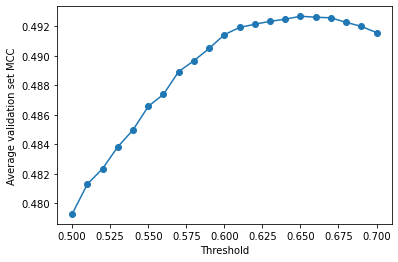

In [50]:
plt.plot(threshs, mccs, 'o-')
plt.xlabel('Threshold')
plt.ylabel('Average validation set MCC')
plt.show()

In [49]:
print("Best MCC thresh:", threshs[np.argmax(mccs)])
print("Best val MCC:", np.max(mccs))

Best MCC thresh: 0.6499999999999999
Best val MCC: 0.4926751534281297


In [51]:
# test set
fold = 'test'
image_ids = splits_df[splits_df['fold'] == fold]['image_id'].values
mcc = get_test_set_mcc(
    image_ids,
    'fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.0003_original-resolution_fromscratch-continued2/Airbus_original',
    label_folder_name='../data/general_blockchain/airbus_labels/large/original/',
    fold=fold,
    threshold=0.65
)
print("Test set MCC:", mcc)

Test set MCC: 0.5044264563807073


In [13]:
# test set: ALL METRICS
fold = 'test'
image_ids = splits_df[splits_df['fold'] == fold]['image_id'].values
mcc, acc, f1 = get_test_set_metrics(
    image_ids,
    'fractal-resunet_Airbus_nfilter-32_depth-6_bs-5_lr-0.0003_original-resolution_fromscratch-continued2/Airbus_original',
    label_folder_name='../data/general_blockchain/airbus_labels/large/original/',
    fold=fold,
    threshold=0.65
)
print("Test set MCC: {:.3f}, accuracy: {:.3f}, f1-score: {:.3f}".format(mcc, acc, f1))

Test set MCC: 0.504, accuracy: 0.905, f1-score: 0.947


## Dataset size experiments